In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from mlp import MLP
import constants
import numpy as np
from tqdm import tqdm
from pyhessian import hessian

In [2]:
mnist_train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./data",
        download = True,
        train = True,
        transform = transforms.Compose([transforms.ToTensor()])
    ),
    batch_size = 10,
    shuffle=True,
)

In [26]:
device = constants.DEVICE
model = MLP().to(device)
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(params=model.parameters())
epochs = 10
loss_landscape = []

In [27]:
def train_fn(data_loader, loss_fn, optim, model):
    loop = tqdm(data_loader)
    loss_val = float('inf')
    for i, (data, targets) in enumerate(loop):
        data, targets = data.to(device), targets.to(device)
        optim.zero_grad()
        data = data.to(device)

        predictions = model(data)
        one_hot = F.one_hot(targets, num_classes = 10).float()
        # print(one_hot.dtype)
        # print(one_hot)
        # print(predictions.dtype)
        # print(predictions)
        loss = loss_fn(predictions, one_hot)
        loss.backward()
        loss_val = loss.item()
    
        optim.step()
        if i % 100 == 0:
            loop.set_postfix(loss=loss.item())
    return loss_val
    

In [28]:
for epoch in range(epochs):
    loss_val = train_fn(mnist_train_loader, loss_fn, optim, model)

100%|██████████| 6000/6000 [00:31<00:00, 192.28it/s, loss=1.78e-6] 


In [29]:
torch.save(model.state_dict(), "small_model_10_epochs.pt")

In [44]:
cap = 5
all_inputs = torch.tensor([])
all_targets = torch.tensor([])
i = 0
for inputs, targets in mnist_train_loader:
    all_inputs = torch.cat([all_inputs, inputs], dim = 0)
    all_targets = torch.cat([all_targets, targets], dim = 0)
    i += 1
    if i == 5:
        break

inputs = all_inputs
targets = all_targets

inputs = inputs.to(device)
targets = targets.to(device).long()
one_hot = F.one_hot(targets, num_classes = 10).float()


hessian_comp = hessian(model, loss_fn, data = (inputs, one_hot), mps=True)

In [58]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print(f"The top eigenvalue of the model is: {top_eigenvalues}")


The top eigenvalue of the model is: [8.300963401794434]


In [72]:
0.5 * top_eigenvector[0]

TypeError: can't multiply sequence by non-int of type 'float'

There is one eigen vector for layer in the network. Are Hessians typically isolated by layer

In [73]:
def get_params(model_orig, model_perb, direction, alpha):
    for m_o, m_p, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_p.data = m_o.data + alpha * d
    return model_perb


# Perturb over largest eigenvector

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0'), tensor([-7.6521e-04, -3.8454e-03, -2.5697e-03, -2.4768e-02,  1.1098e-04,
         1.8581e-02, -4.3335e-03,  0.0000e+00, -8.9387e-05, -1.0260e-04,
         0.0000e+00,  0.0000e+00, -6.5535e-03, -7.1099e-03, -2.3206e-04,
         1.0478e-04,  1.5156e-04,  1.1369e-05,  0.0000e+00,  9.9884e-03,
        -3.7230e-05, -7.2906e-03, -1.2222e-02, -9.6831e-04,  9.2925e-05,
        -2.9463e-03, -3.0612e-04,  0.0000e+00,  0.0000e+00, -1.1173e-03,
         2.4107e-05,  0.0000e+00,  1.7013e-03,  1.0475e-06,  8.3132e-04,
         2.8832e-04,  1.0385e-05,  0.0000e+00,  1.5082e-03,  2.0284e-03,
         2.6302e-03, -1.6364e-02,  2.0442e-02, -5.6873e-03, -5.1303e-04,
        -8.6496e-04,  1.2688e-02,  0.0000e+00, -3.3988e-03, -1.4449e-02

Text(0.5, 0, 'Perturbation')

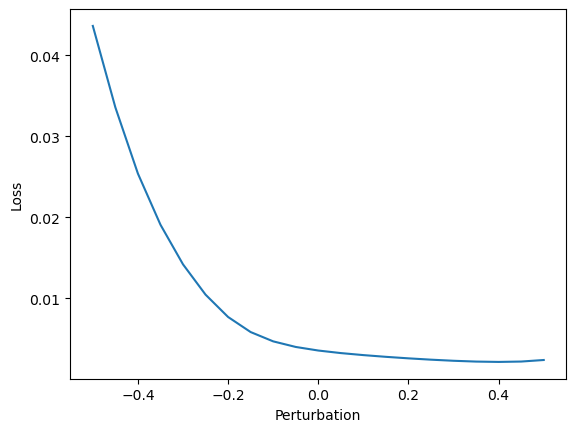

In [74]:
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# model copy
model_perb = MLP().to(device)
model_perb.load_state_dict(torch.load("./small_model_10_epochs.pt"))
model_perb.eval()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(loss_fn(model_perb(inputs), one_hot).item())

plt.plot(lams, loss_list)
plt.ylabel("Loss")
plt.xlabel("Perturbation")

# Perturb over top 2 eigenvectors

In [80]:
def perturb_2d(model_orig, model_perb, v1, v2, lam1, lam2):
    for m_o, m_p, v_1, v_2 in zip(model_orig.parameters(), model_perb.parameters(), v1, v2):
        m_p.data = m_o.data + lam1 * v_1 + lam2 * v_2
    return model_perb

In [81]:
top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
print(f"The top eigenvalue of the model is: {top_eigenvalues}")

The top eigenvalue of the model is: [8.295567512512207, 3.6269779205322266]


ValueError: Argument Z must be 2-dimensional.

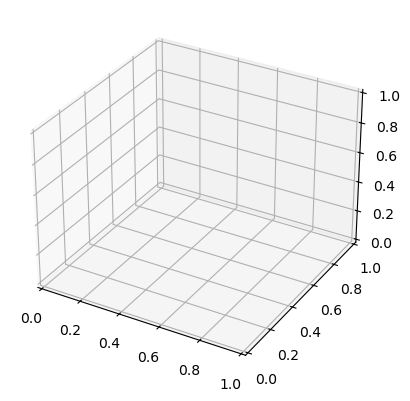

In [83]:
lams_x = np.linspace(-0.5, 0.5, 21).astype(np.float32)
lams_y = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_grid = np.zeros((len(lams_x), len(lams_y)))

# model copy
model_perb = MLP().to(device)
model_perb.load_state_dict(torch.load("./small_model_10_epochs.pt"))
model_perb.eval()

for i, x_dev in enumerate(lams_x):
    for j, y_dev in enumerate(lams_y):
        # print(x_dev, y_dev)
        model_perb = perturb_2d(model, model_perb, top_eigenvectors[0], top_eigenvectors[1], x_dev, y_dev)
        loss_grid[i, j] = loss_fn(model_perb(inputs), one_hot).item()

loss_list = np.array(loss_list)
xv, yv = np.meshgrid(lams_x, lams_y, indexing = "ij")
fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})
surf = ax.plot_surface(xv, yv, loss_list)
plt.show()

In [5]:
state_dict = model.state_dict()
curr_weights = None
for key, value in state_dict.items():
    value = value.flatten()
    print(key)
    print(value.shape)
    if curr_weights is not None:
        curr_weights = torch.cat([curr_weights, value], axis = 0)
    else:
        curr_weights = value
curr_weights.shape

linear_architecture_small.0.weight
torch.Size([78400])
linear_architecture_small.0.bias
torch.Size([100])
linear_architecture_small.2.weight
torch.Size([1000])
linear_architecture_small.2.bias
torch.Size([10])


torch.Size([79510])